# **Assignment 9 - Advanced Computer Vision**

![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

## **Face recognition**
Task is to recognize faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

# **Code**

### Making Imports here

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import cv2
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Reshape, ZeroPadding2D
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import random 
random.seed(0)
import os

### Mount Google drive if you are using google colab
- Mounted my own Gdrive and hosted the different datasets and models there as shortcuts (based on existing links shared)



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Change current working directory to project folder (1 mark)
- Changed to my own working folder

In [3]:
#### Add your code here ####
folder_path = ("/content/drive/My Drive/Data/")
os.chdir(folder_path)

### Extract the zip file (2 marks)
- Extract Aligned Face Dataset from Pinterest.zip
- Zip extracted to our working folder
- Also added check to make sure we arent redoing the extraction

In [4]:
#### Add your code here ####
####Added a check to not redo the extraction if the files exist already####
if not os.path.exists(folder_path+"PINS"):
  images_zip_path = folder_path + "Aligned Face Dataset from Pinterest.zip"
  from zipfile import ZipFile
  with ZipFile(images_zip_path,"r") as z:
    z.extractall(path = folder_path)
  print("Images extracted")
else:
  print("exists already")

exists already


### Function to load images - Predefined Function
- Define a function to load the images from the extracted folder and map each image with person id 


In [5]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

### Examining the metadata

In [30]:
metadata[3]

PINS/pins_Aaron Paul/Aaron Paul101_249.jpg

### Define function to load image - Predefined Function
- Define a function to load image from the metadata

In [6]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image (2 marks)
- Load one image using the function "load_image"
- Showing the image additionally as well

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

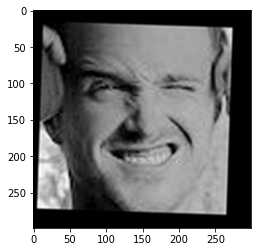

In [7]:
#### Add your code here ####
aaron_paul = load_image("PINS/pins_Aaron Paul/Aaron Paul2_293.jpg")
plt.imshow(aaron_paul)
aaron_paul

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model (2 marks)
- Load the model defined above
- Loaded the given weight file named "vgg_face_weights.h5" from GDrive

In [29]:
model = vgg_face() 
WEIGHTS_FILE = folder_path + "vgg_face_weights.h5" ##picking up weights from GDrive
model.load_weights(WEIGHTS_FILE)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_13 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 112, 112, 128)    

### Get vgg_face_descriptor - Predefined Function

In [10]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset - Predefined Function
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [11]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images (5 marks)
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [12]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
  #### Add your code here ####
  img_path = m.image_path()
  try:
    img = load_image(img_path)
  except:
    embeddings[i] = np.zeros((1,2622))
    continue
  # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
  img = (img / 255.).astype(np.float32)
  img = cv2.resize(img, dsize = (224,224))
  embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]


### Function to calculate distance between given 2 pairs of images - Predefined Function

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [14]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below - Predefined Function
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

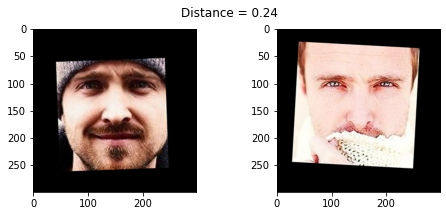

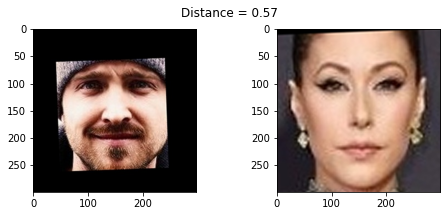

In [15]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

### Create train and test sets (5 marks)
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [16]:
indices = np.random.permutation(embeddings.shape[0]) ##creating a random permutation of the array indices
test_idx, train_idx  = indices[:1077], indices[1077:] #breaking up the indices generated for a 10% test set
print (test_idx)

[ 3669  4466  1582 ... 10353  6270  1112]


In [17]:
##### commented this as I did not have surety around the order of the images #####
#train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
#test_idx = np.arange(metadata.shape[0]) % 9 == 0

## Train set
X_train = embeddings[train_idx]
## Test set
X_test = embeddings[test_idx]


targets = np.array([m.name for m in metadata])
#train labels
y_train = targets[train_idx]
#test labels
y_test = targets[test_idx]

In [31]:
y_test

array(['pins_Maisie Williams', 'pins_Natalie Portman ',
       'pins_Cobie Smulders', ..., 'pins_shakira',
       'pins_Wentworth Miller', 'pins_Cameron Monaghan'], dtype='<U29')

### Encode the Labels (3 marks)
- Encode the targets
- Use LabelEncoder

In [19]:
from sklearn.preprocessing import LabelEncoder

## Made encoder global so that it can be accessed in the final question
encoder = LabelEncoder()
## Fitted the entire set of labels to ensure no misses during testing
targets_encoded = encoder.fit_transform(targets)
def generate_encoding(classes):
  transformed_labels = encoder.transform(classes) ## only performing transformation inside the method
  return transformed_labels
#### Add your code here ####
#### encoding the training and testing labels
y_train_labels = generate_encoding(y_train)
y_test_labels = generate_encoding(y_test)

### Print the labels as a test

In [32]:
y_train_labels

array([76, 49, 66, ..., 91, 24, 72])

### Standardize the feature values (3 marks)
- Scale the features using StandardScaler

In [20]:
# Standarize features
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_train = ss.fit_transform(X_train)##fit on X_train as we do not want the peek ahead problem to come in here
x_test = ss.transform(X_test)
#### Add your code here ####

### Reduce dimensions using PCA (3 marks)
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [21]:
from sklearn.decomposition import PCA

#### Create PCA ####
pca = PCA(n_components=128)
pca.fit(x_train)

#### Fit PCA train and Test ####
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

### Build a Classifier (3 marks) - Without Encoded Labels. With Encoded labels done after this
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score
### If we didnt use the encoded labels, we can still see the indvidual names directly

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

#### Create SVC ####
#### Note, we may be able to marginally improve the accuracy further, however, given that we are at 96%+ no further optimization is done##
svc_ = SVC(class_weight = "balanced")
svc_.fit(x_train_pca, y_train)

##Making Predictions 
y_pred = svc_.predict(x_test_pca)

#### Classification Report ####
print(classification_report(y_test, y_pred))

#### Print Score ####
print("Accuracy is:" , round(svc_.score(x_test_pca,y_test) * 100,2))


                               precision    recall  f1-score   support

              pins_Aaron Paul       1.00      1.00      1.00         8
            pins_Alvaro Morte       0.86      1.00      0.92         6
             pins_Amanda Crew       1.00      0.94      0.97        18
          pins_Amaury Nolasco       1.00      1.00      1.00         7
               pins_Anna Gunn       1.00      0.90      0.95        10
    pins_Benedict Cumberbatch       1.00      1.00      1.00        12
            pins_Betsy Brandt       1.00      1.00      1.00         9
        pins_Brenton Thwaites       1.00      1.00      1.00        14
            pins_Brit Marling       0.93      1.00      0.97        14
          pins_Bryan Cranston       1.00      1.00      1.00         9
              pins_Caity Lotz       0.87      1.00      0.93        13
        pins_Cameron Monaghan       1.00      1.00      1.00        10
          pins_Chance Perdomo       1.00      1.00      1.00         6
     

### Build a Classifier (3 marks) - With Encoded Labels
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [36]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

#### Create SVC ####
#### Note, we may be able to marginally improve the accuracy further, however, given that we are at 96%+ no further optimization is done##
svc_ = SVC(class_weight = "balanced")
svc_.fit(x_train_pca, y_train_labels)

##Making Predictions 
y_pred = svc_.predict(x_test_pca)

#### Classification Report ####
print(classification_report(y_test_labels, y_pred))

#### Print Score ####
print("Accuracy is:" , round(svc_.score(x_test_pca,y_test_labels) * 100,2))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.86      1.00      0.92         6
           2       1.00      0.94      0.97        18
           3       1.00      1.00      1.00         7
           4       1.00      0.90      0.95        10
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00        14
           8       0.93      1.00      0.97        14
           9       1.00      1.00      1.00         9
          10       0.87      1.00      0.93        13
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00         6
          13       0.82      0.90      0.86        10
          14       1.00      1.00      1.00        11
          15       1.00      1.00      1.00         9
          16       0.87      0.93      0.90        14
          17       0.92    

### Test results (1 mark)
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

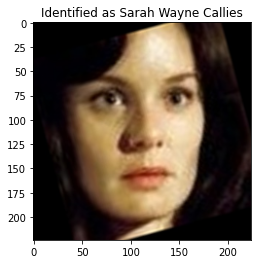

In [37]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_image = (example_image / 255.).astype(np.float32)

example_image = cv2.resize(example_image, dsize = (224,224))
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(example_image, axis=0))[0]

## Reshaping the test sample
embedding_vector = embedding_vector.reshape(1,2622)

# scaling the test sample
embedding_vector = ss.transform(embedding_vector)

# pca on the test sample
embedding_vector_pca = pca.transform(embedding_vector)

example_prediction = svc_.predict(embedding_vector_pca)

example_identity = encoder.inverse_transform(example_prediction)[0] ## we would not need this step if we did not encode the targets

plt.imshow(example_image)
##Removing the extra fluff in the predicted label
plt.title(f'Identified as {example_identity.replace("pins_","").replace("face","")}');

# **Assignment End**